UNIFIED: ATTRACTOR NETWORK POPULATION WITH MFR ANALYSIS

✓ Created population of 100 neurons
  Recurrent weight matrix W: (100, 100)
  Time constant τ: 0.1 s

EXPERIMENT 1: Varying Constant Input Strength
  Input strength: 0.00
  Input strength: 0.22
  Input strength: 0.44
  Input strength: 0.67
  Input strength: 0.89
  Input strength: 1.11
  Input strength: 1.33
  Input strength: 1.56
  Input strength: 1.78
  Input strength: 2.00

Results (Constant Input):
  I=0.00 → MFR=30.04 Hz
  I=0.22 → MFR=37.03 Hz
  I=0.44 → MFR=48.42 Hz
  I=0.67 → MFR=57.12 Hz
  I=0.89 → MFR=64.28 Hz
  I=1.11 → MFR=73.01 Hz
  I=1.33 → MFR=82.51 Hz
  I=1.56 → MFR=92.12 Hz
  I=1.78 → MFR=101.72 Hz
  I=2.00 → MFR=111.57 Hz

EXPERIMENT 2: Varying Oscillating Input Strength
  Input strength: 0.00
  Input strength: 0.22
  Input strength: 0.44
  Input strength: 0.67
  Input strength: 0.89
  Input strength: 1.11
  Input strength: 1.33
  Input strength: 1.56
  Input strength: 1.78
  Input strength: 2.00

Results (Oscill

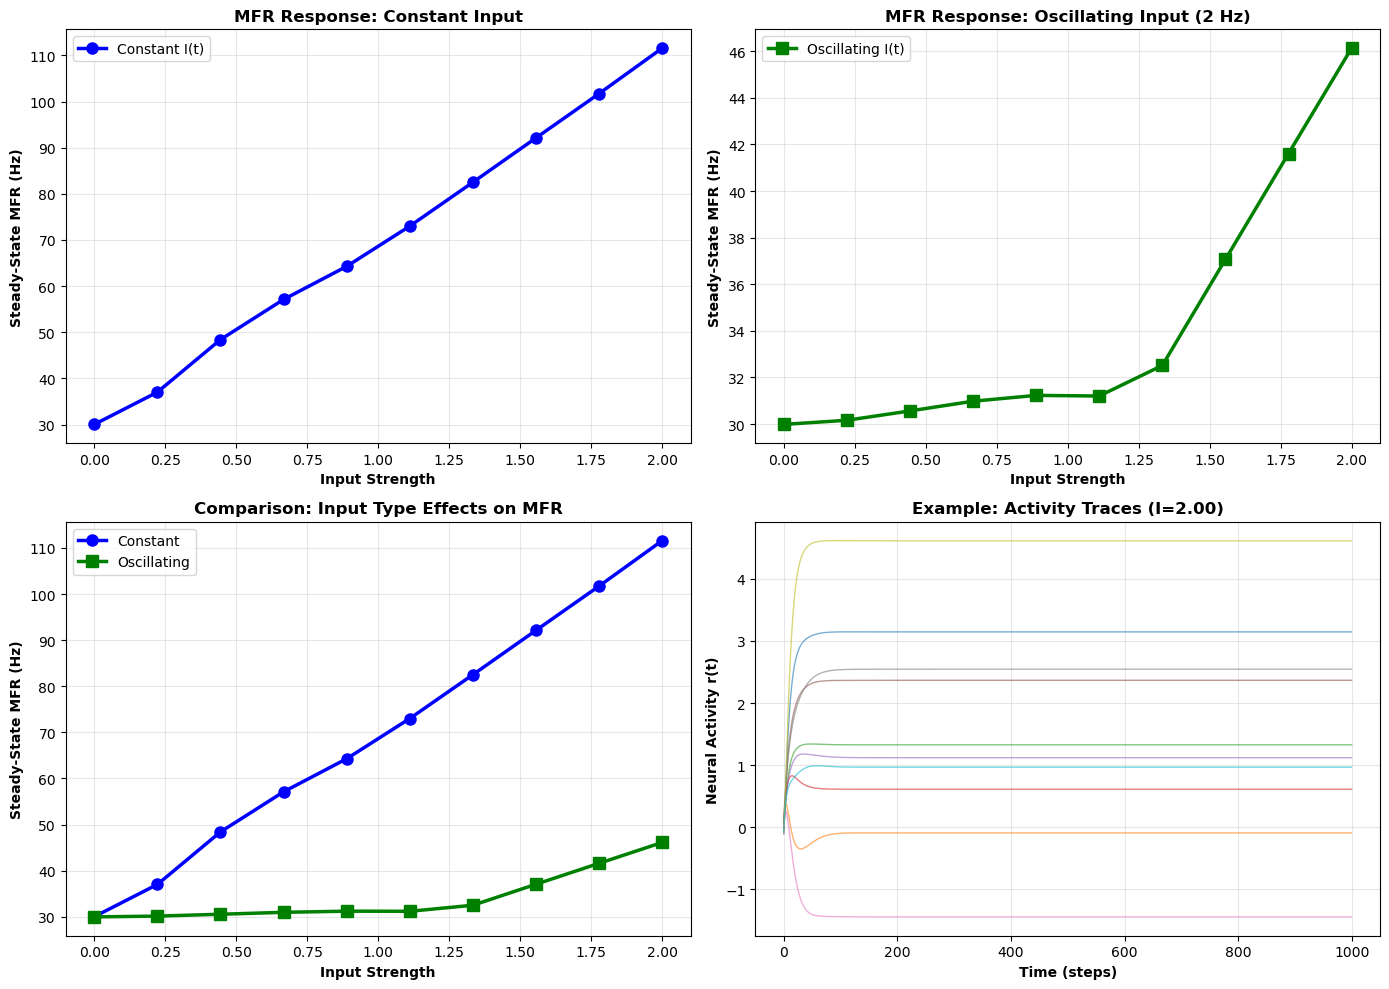

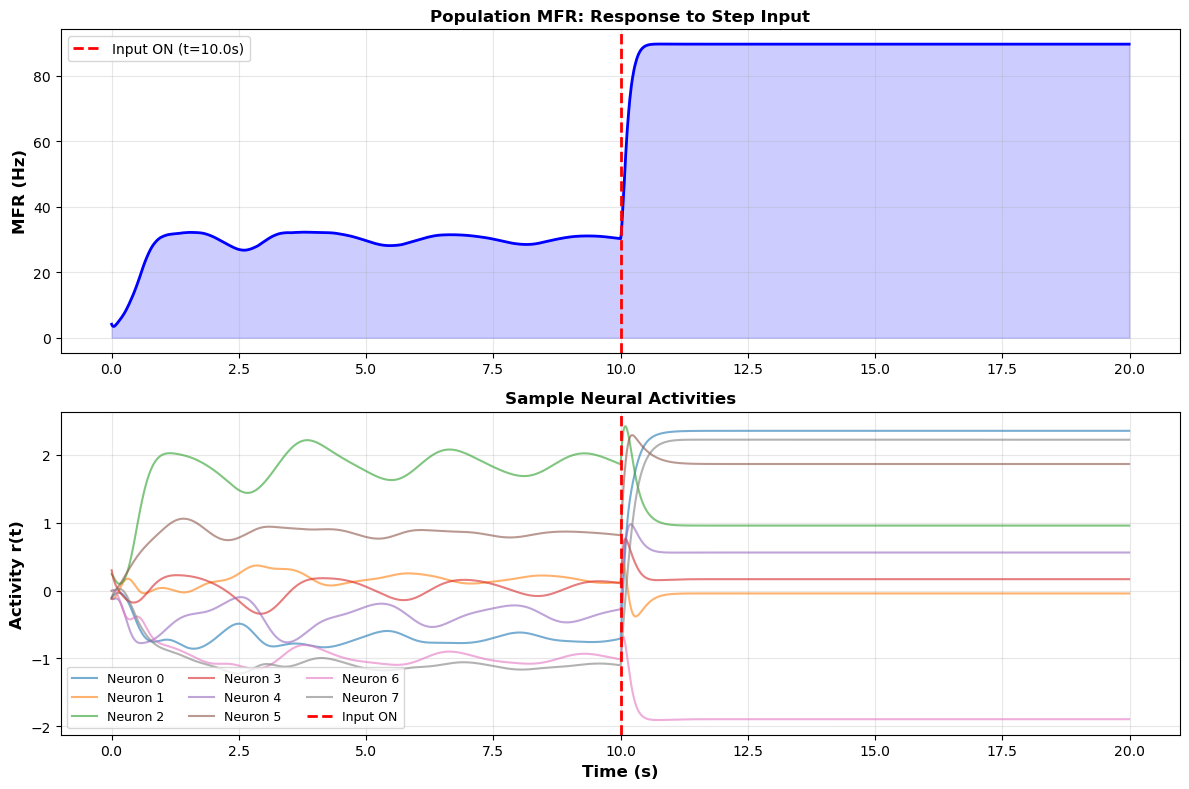

In [5]:
"""
Unified Attractor Network: Population Activity → MFR Analysis

This code creates a SINGLE attractor network and measures its MFR under different input conditions.
The network itself is the population; its continuous-valued activity r(t) is what generates the MFR.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# ============================================================================
# SINGLE ATTRACTOR NETWORK (this IS the population)
# ============================================================================

class AttractorNetworkPopulation:
    """
    Continuous-rate RNN that serves as the population.
    
    Dynamics: τ ṙ(t) = -r(t) + W φ(r(t)) + I(t)
    where r(t) ∈ R^N is the activity of N neurons
    
    The MFR is computed as: m(t) = mean(|r(t)|) or mean(r(t)) depending on activation fn
    """
    
    def __init__(self, N=100, tau=0.1, g=1.5, bias=0.0):
        """
        N: number of neurons (population size)
        tau: time constant
        g: weight scaling (controls network regime: subcritical, critical, chaotic)
        bias: baseline input to all neurons
        """
        self.N = N
        self.tau = tau
        self.g = g
        self.bias = bias
        
        # Random recurrent connectivity
        self.W = (g / np.sqrt(N)) * np.random.randn(N, N)
    
    def phi(self, r):
        """Activation function: tanh (bounded between -1 and 1)"""
        return np.tanh(r)
    
    def compute_mfr(self, r):
        """
        Mean Firing Rate: average absolute activity across population.
        With tanh activation, this is normalized to [0, 1] approximately.
        To get Hz, multiply by a conversion factor (e.g., max_firing_rate).
        """
        return np.mean(np.abs(r))
    
    def dynamics(self, r, t, I_func):
        """
        RNN dynamics: τ ṙ = -r + W φ(r) + I_ext + I_bias
        
        r: population activity (N,)
        t: time
        I_func: callable returning external input at time t
        """
        I_ext = I_func(t)
        phi_r = self.phi(r)
        I_total = I_ext + self.bias * np.ones(self.N)
        
        drdt = (-r + self.W @ phi_r + I_total) / self.tau
        return drdt
    
    def simulate(self, t, I_func, r0=None):
        """
        Simulate network dynamics over time.
        
        Returns:
            r_trajectory: (len(t), N) activity of all neurons
        """
        if r0 is None:
            r0 = 0.1 * np.random.randn(self.N)
        
        r_traj = odeint(self.dynamics, r0, t, args=(I_func,), atol=1e-6, rtol=1e-4)
        return r_traj
    
    def compute_mfr_trajectory(self, r_trajectory, max_firing_rate=50.0):
        """
        Compute MFR over entire trajectory.
        
        Args:
            r_trajectory: (T, N) activity trajectory
            max_firing_rate: conversion factor from normalized activity to Hz
        
        Returns:
            mfr: (T,) mean firing rate in Hz
        """
        mfr_normalized = np.array([self.compute_mfr(r_trajectory[i]) for i in range(len(r_trajectory))])
        mfr_hz = mfr_normalized * max_firing_rate
        return mfr_hz


# ============================================================================
# EXPERIMENTS: HOW EXTERNAL INPUT I(t) AFFECTS MFR
# ============================================================================

def experiment_constant_input(network, duration=10, dt=0.01, input_strengths=None):
    """
    Vary constant external input I(t) = strength × ones(N)
    Measure how MFR changes with input strength.
    """
    if input_strengths is None:
        input_strengths = np.linspace(0, 2.0, 10)
    
    t = np.arange(0, duration, dt)
    results = {'strengths': input_strengths, 'mfrs': [], 'trajectories': []}
    
    for strength in input_strengths:
        print(f"  Input strength: {strength:.2f}")
        
        # Constant input
        I_func = lambda t, s=strength: s * np.ones(network.N)
        
        # Simulate (let it settle for first half, then measure)
        r_traj = network.simulate(t, I_func)
        
        # Compute MFR during second half (steady state)
        t_settle = int(len(t) * 0.5)
        mfr_steady = np.mean(network.compute_mfr_trajectory(r_traj[t_settle:], max_firing_rate=50.0))
        
        results['mfrs'].append(mfr_steady)
        results['trajectories'].append(r_traj)
    
    results['mfrs'] = np.array(results['mfrs'])
    return results, t


def experiment_oscillating_input(network, duration=10, dt=0.01, input_strengths=None, freq=2.0):
    """
    Oscillating input: I(t) = strength × sin(2πf·t) × ones(N)
    """
    if input_strengths is None:
        input_strengths = np.linspace(0, 2.0, 10)
    
    t = np.arange(0, duration, dt)
    results = {'strengths': input_strengths, 'mfrs': [], 'trajectories': []}
    
    for strength in input_strengths:
        print(f"  Input strength: {strength:.2f}")
        
        # Oscillating input
        I_func = lambda t, s=strength, f=freq: s * np.sin(2*np.pi*f*t) * np.ones(network.N)
        
        r_traj = network.simulate(t, I_func)
        
        # Measure in steady state
        t_settle = int(len(t) * 0.5)
        mfr_steady = np.mean(network.compute_mfr_trajectory(r_traj[t_settle:], max_firing_rate=50.0))
        
        results['mfrs'].append(mfr_steady)
        results['trajectories'].append(r_traj)
    
    results['mfrs'] = np.array(results['mfrs'])
    return results, t


def experiment_step_input(network, duration=20, dt=0.01, step_time=10.0, input_strength=1.0):
    """
    Step input: turn on I(t) = strength at t = step_time
    See how network responds and MFR adapts over time.
    """
    t = np.arange(0, duration, dt)
    
    def I_func(t, step_t=step_time, strength=input_strength):
        if t >= step_t:
            return strength * np.ones(network.N)
        else:
            return np.zeros(network.N)
    
    print(f"  Simulating step input (strength={input_strength})")
    r_traj = network.simulate(t, I_func)
    mfr_traj = network.compute_mfr_trajectory(r_traj, max_firing_rate=50.0)
    
    return t, r_traj, mfr_traj


# ============================================================================
# PLOTTING
# ============================================================================

def plot_mfr_response(const_results, osc_results, network):
    """Plot MFR response to varying input strengths"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # ===== Plot 1: Constant Input Response =====
    ax = axes[0, 0]
    ax.plot(const_results['strengths'], const_results['mfrs'], 'o-', 
            linewidth=2.5, markersize=8, color='blue', label='Constant I(t)')
    ax.set_xlabel('Input Strength', fontweight='bold')
    ax.set_ylabel('Steady-State MFR (Hz)', fontweight='bold')
    ax.set_title('MFR Response: Constant Input', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # ===== Plot 2: Oscillating Input Response =====
    ax = axes[0, 1]
    ax.plot(osc_results['strengths'], osc_results['mfrs'], 's-', 
            linewidth=2.5, markersize=8, color='green', label='Oscillating I(t)')
    ax.set_xlabel('Input Strength', fontweight='bold')
    ax.set_ylabel('Steady-State MFR (Hz)', fontweight='bold')
    ax.set_title('MFR Response: Oscillating Input (2 Hz)', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # ===== Plot 3: Comparison =====
    ax = axes[1, 0]
    ax.plot(const_results['strengths'], const_results['mfrs'], 'o-', 
            linewidth=2.5, markersize=8, color='blue', label='Constant')
    ax.plot(osc_results['strengths'], osc_results['mfrs'], 's-', 
            linewidth=2.5, markersize=8, color='green', label='Oscillating')
    ax.set_xlabel('Input Strength', fontweight='bold')
    ax.set_ylabel('Steady-State MFR (Hz)', fontweight='bold')
    ax.set_title('Comparison: Input Type Effects on MFR', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # ===== Plot 4: Example trajectory (max input) =====
    ax = axes[1, 1]
    # Show first 2000 steps of a high-input trajectory
    traj_example = const_results['trajectories'][-1][:2000]
    for i in range(min(10, network.N)):
        ax.plot(traj_example[:, i], alpha=0.6, linewidth=1)
    ax.set_xlabel('Time (steps)', fontweight='bold')
    ax.set_ylabel('Neural Activity r(t)', fontweight='bold')
    ax.set_title(f'Example: Activity Traces (I={const_results["strengths"][-1]:.2f})', 
                 fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def plot_step_response(t, r_traj, mfr_traj, step_time=10.0):
    """Plot temporal response to step input"""
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # ===== MFR over time =====
    ax = axes[0]
    ax.plot(t, mfr_traj, linewidth=2, color='blue')
    ax.axvline(step_time, color='red', linestyle='--', linewidth=2, label=f'Input ON (t={step_time}s)')
    ax.fill_between(t, 0, mfr_traj, alpha=0.2, color='blue')
    ax.set_ylabel('MFR (Hz)', fontweight='bold', fontsize=12)
    ax.set_title('Population MFR: Response to Step Input', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    # ===== Sample neural activities =====
    ax = axes[1]
    for i in range(min(8, r_traj.shape[1])):
        ax.plot(t, r_traj[:, i], alpha=0.6, linewidth=1.5, label=f'Neuron {i}')
    ax.axvline(step_time, color='red', linestyle='--', linewidth=2, label='Input ON')
    ax.set_xlabel('Time (s)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Activity r(t)', fontweight='bold', fontsize=12)
    ax.set_title('Sample Neural Activities', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, ncol=3)
    
    plt.tight_layout()
    return fig


# ============================================================================
# MAIN
# ============================================================================

if __name__ == '__main__':
    print("=" * 80)
    print("UNIFIED: ATTRACTOR NETWORK POPULATION WITH MFR ANALYSIS")
    print("=" * 80)
    
    # Create a single attractor network that serves as the population
    network = AttractorNetworkPopulation(
        N=100,      # 100 neurons = the population
        tau=0.1,    # 100 ms time constant
        g=1.5,      # Slightly chaotic regime
        bias=0.0    # No baseline input
    )
    
    print(f"\n✓ Created population of {network.N} neurons")
    print(f"  Recurrent weight matrix W: ({network.N}, {network.N})")
    print(f"  Time constant τ: {network.tau} s")
    
    # ============ EXPERIMENT 1: CONSTANT INPUT ============
    print("\n" + "=" * 80)
    print("EXPERIMENT 1: Varying Constant Input Strength")
    print("=" * 80)
    
    input_strengths = np.linspace(0, 2.0, 10)
    const_results, t_const = experiment_constant_input(
        network, duration=10, dt=0.01, input_strengths=input_strengths
    )
    
    print("\nResults (Constant Input):")
    for s, mfr in zip(const_results['strengths'], const_results['mfrs']):
        print(f"  I={s:.2f} → MFR={mfr:.2f} Hz")
    
    # ============ EXPERIMENT 2: OSCILLATING INPUT ============
    print("\n" + "=" * 80)
    print("EXPERIMENT 2: Varying Oscillating Input Strength")
    print("=" * 80)
    
    osc_results, t_osc = experiment_oscillating_input(
        network, duration=10, dt=0.01, input_strengths=input_strengths, freq=2.0
    )
    
    print("\nResults (Oscillating Input, 2 Hz):")
    for s, mfr in zip(osc_results['strengths'], osc_results['mfrs']):
        print(f"  I={s:.2f} → MFR={mfr:.2f} Hz")
    
    # ============ EXPERIMENT 3: STEP INPUT ============
    print("\n" + "=" * 80)
    print("EXPERIMENT 3: Step Input Response")
    print("=" * 80)
    
    t_step, r_step, mfr_step = experiment_step_input(
        network, duration=20, dt=0.01, step_time=10.0, input_strength=1.5
    )
    
    print("\nStep Input Results:")
    print(f"  Before step (t<10s): MFR={np.mean(mfr_step[:1000]):.2f} Hz")
    print(f"  After step (t>10s): MFR={np.mean(mfr_step[1000:]):.2f} Hz")
    print(f"  Response time: ~{np.where(mfr_step > 0.5*np.max(mfr_step))[0][0] * 0.01:.2f} s")
    
    # ============ PLOTTING ============
    print("\n" + "=" * 80)
    print("GENERATING PLOTS")
    print("=" * 80)
    
    # Plot 1: MFR response surfaces
    fig1 = plot_mfr_response(const_results, osc_results, network)
    
    # Plot 2: Step response
    fig2 = plot_step_response(t_step, r_step, mfr_step, step_time=10.0)
    
    print("\n" + "=" * 80)
    print("SUMMARY")
    print("=" * 80)
    print("""
The network's MFR increases monotonically with input strength.
Oscillating inputs produce lower MFRs than constant inputs (temporal filtering).
The population is a single attractor network: r(t) IS the population activity.
    """)
    
    plt.show()